In [47]:
import pandas as pd

import anndata as ad
import scanpy as sc

import time

from SC2Spa import ME, Vis

/mnt/win1
/mnt/win1/SC2Spa_Notebook/MouseHippocampus_SSV2


In [15]:
import numpy as np
import pandas as pd

import math
from scipy.stats import binom
from multiprocessing import Pool


def Count_Prob_EEI(A):
    # A: gene expression matrix with the dimension of (n_cell, n_gene)
    # Prob_excl[i, j]: the probability that gene i is expressed
    # but gene j is not expressed
    # Count_excl[i, j]: number of occurrence that gene i is expressed
    # but gene j is not expressed

    Allcell = A.shape[0]
    Allgene = A.shape[1]

    Count_excl = np.zeros((Allgene, Allgene), dtype=np.int64)
    is_nonzeroMat = (A.values > 0.05)
    is_zeroMat = (A.values <= 0.05)

    for i in range(Allgene):
        Count_excl[i] = np.sum(np.logical_and(is_nonzeroMat[:, [i]],
                                              is_zeroMat), axis=0)
    p_nonzero = np.sum(A.values > 0.05, axis=0) / Allcell
    p_zero = np.sum(A.values <= 0.05, axis=0) / Allcell

    Prob_excl = p_nonzero * p_zero[:, np.newaxis]

    return Count_excl, Prob_excl

def BME_sub(ij, Count_excl, Prob_excl, A_S, A_E, genes, n_cell, p_coef):
    
    '''
        Mutual exclusivity analysis (subprocess)

        Args:
            ij: 

        Returns
        -------

    '''
    
    DEEI = pd.DataFrame(np.zeros((len(ij), 7), dtype=np.float64),
             columns = ['Gene1', 'Gene2', 'BME', 'DEEI(1Express_2Silence)',
                        'P(1E_2S)', 'DEEI(1Silence_2Express)', 'P(1S_2E)'])

    for count, ijt in enumerate(ij):
        
        i,j = ijt

        #BME
        e1 = (A_S.iloc[:, i] & A_E.iloc[:, j]).sum()
        e2 = (A_S.iloc[:, j] & A_E.iloc[:, i]).sum()
        e12sumsqr = e1 ** 2 + e2 ** 2
        e1e2 = e1 * e2
        penalty = (e12sumsqr + 2 * e1e2) / e12sumsqr / 2
        e = (e1 + e2) / n_cell * (penalty ** p_coef)

        DEEI.loc[count, 'BME'] = e

        #DEEI
        x1 = Count_excl[i][j]
        p1 = Prob_excl[i][j]
        prob1 = binom.sf(x1 - 1, n_cell, p1)

        x2 = Count_excl[j][i]
        p2 = Prob_excl[j][i]
        prob2 = binom.sf(x2 - 1, n_cell, p2)

        DEEI.loc[count, 'Gene1'] = genes[i]
        DEEI.loc[count, 'Gene2'] = genes[j]
        DEEI.loc[count, 'Prob(1E_2S)'] = prob1
        DEEI.loc[count, 'Prob(1S_2E)'] = prob2

        if (prob1 <= 0):
            deei_1e2s = 1e3
        else:
            deei_1e2s = -(math.log10(prob1))
        if (prob2 <= 0):
            deei_1s2e = 1e3
        else:
            deei_1s2e = -(math.log10(prob2))

        DEEI.loc[count, 'DEEI(1Express_2Silence)'] = deei_1e2s
        DEEI.loc[count, 'DEEI(1Silence_2Express)'] = deei_1s2e
        
    return DEEI
    
def BME(A, cutoff=0.05, p_coef=1, n_process= 16):

    '''
        Mutual exclusivity analysis

        Args:
            A: Gene expression matrix (n_cell x n_gene)

        Returns
        -------

    '''

    Count_excl, Prob_excl = Count_Prob_EEI(A)

    A_S = A < cutoff
    A_E = A >= cutoff

    genes = A.columns.tolist()
    n_cell = A.shape[0]
    n_gene = A.shape[1]
    

    ij = []
    for i in range(0, n_gene):
        for j in range(i + 1, n_gene):
            ij.append([i, j])

    step = int(len(ij) / n_process)
    ijs = [ij[i*step:(i+1)*step] for i in range(n_process-1)]
    ijs.append(ij[(n_process-1)*step:])
    
    with Pool(n_process) as p:
        DEEI = p.starmap(BME_sub, [(ij, Count_excl, Prob_excl,
                                    A_S, A_E, genes, n_cell, p_coef) for ij in ijs])
    
    DEEI = pd.concat(DEEI).sort_values('BME', ascending = False).reset_index(drop = True)

    return DEEI

In [16]:
adata = ad.read_h5ad('../Dataset/AdataMH1.h5ad')
adata.var_names_make_unique()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

df = pd.DataFrame(adata.X.toarray(),
                  columns = adata.var_names.tolist(),
                  index = adata.obs_names.tolist())

LPG = pd.read_csv('GeneInfo/LPG_HC1.csv', index_col = 0)
MI = pd.read_csv('../SVA_BM/MoransI/MI_HC1.csv', index_col = 0)
LPG = LPG.merge(MI, how = 'left', left_index = True, right_index = True)

threMI = 0.02
LPG = LPG.sort_values('imp_sumup_norm', ascending = False).iloc[:2048]
GeneSelected = LPG[LPG['I'] > threMI].index.tolist()

df_selected = df[GeneSelected]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
df_selected.shape

(35349, 1262)

In [18]:
sta = time.time()

#BME_score = ME.BME(df_selected)
BME_score = BME(df_selected)

end = time.time()
print((end - sta) / 60.0, 'min')

/home/linbuliao/anaconda3/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:75: RuntimeWarning: divide by zero encountered in _binom_sf
  return _boost._binom_sf(k, n, p)
/home/linbuliao/anaconda3/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:75: RuntimeWarning: divide by zero encountered in _binom_sf
  return _boost._binom_sf(k, n, p)
/home/linbuliao/anaconda3/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:75: RuntimeWarning: divide by zero encountered in _binom_sf
  return _boost._binom_sf(k, n, p)
/home/linbuliao/anaconda3/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:75: RuntimeWarning: divide by zero encountered in _binom_sf
  return _boost._binom_sf(k, n, p)
/home/linbuliao/anaconda3/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:75: RuntimeWarning: divide by zero encountered in _binom_sf
  return _boost._binom_sf(k, n, p)
/home/linbuliao/anaconda3/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:75: Runti

9.623833898703257 min


In [42]:
print(BME_score.shape)
BME_score.head()

(795691, 7)


Gene1  Gene2       BME  DEEI(1Express_2Silence)    Prob(1E_2S)  \
0   CAMK2A   PLP1  0.495297                -0.000000   1.000000e+00   
1     NRGN   MOBP  0.490610               163.112214  7.722998e-164   
2  MT-RNR2  THBS4  0.486845              1000.000000   0.000000e+00   
3  MT-RNR2   MYOC  0.485869              1000.000000   0.000000e+00   
4  MT-RNR2    VIP  0.484964              1000.000000   0.000000e+00   

   DEEI(1Silence_2Express)  Prob(1S_2E)  
0                   1000.0          0.0  
1                     -0.0          1.0  
2                     -0.0          1.0  
3                     -0.0          1.0  
4                     -0.0          1.0

In [44]:
BME_score.iloc[:1000].to_csv('GeneInfo/BME_score.csv', index = None)

# Visualize

In [45]:
BME_score = pd.read_csv('GeneInfo/BME_score.csv')

In [46]:
BME_score

Gene1    Gene2       BME  DEEI(1Express_2Silence)    Prob(1E_2S)  \
0     CAMK2A     PLP1  0.495297                -0.000000   1.000000e+00   
1       NRGN     MOBP  0.490610               163.112214  7.722998e-164   
2    MT-RNR2    THBS4  0.486845              1000.000000   0.000000e+00   
3    MT-RNR2     MYOC  0.485869              1000.000000   0.000000e+00   
4    MT-RNR2      VIP  0.484964              1000.000000   0.000000e+00   
..       ...      ...       ...                      ...            ...   
995  MT-CYTB      SMS  0.437242              1000.000000   0.000000e+00   
996  MT-RNR1  KBTBD11  0.437216              1000.000000   0.000000e+00   
997   MT-ND1   LIMCH1  0.437190              1000.000000   0.000000e+00   
998   MT-ND4     TAC1  0.437184              1000.000000   0.000000e+00   
999   ATP1A2    YWHAZ  0.437182                -0.000000   1.000000e+00   

     DEEI(1Silence_2Express)  Prob(1S_2E)  
0                1000.000000     0.000000  
1                  -0.000000     1.000000  
2                  -0.000000     1.000000  
3                  -0.000000     1.000000  
4                  -0.000000     1.000000  
..                       ...          ...  
995                -0.000000     1.000000  
996                -0.000000     1.000000  
997                -0.000000     1.000000  
998                -0.000000     1.000000  
999                 4.480067     0.000033  

[1000 rows x 7 columns]

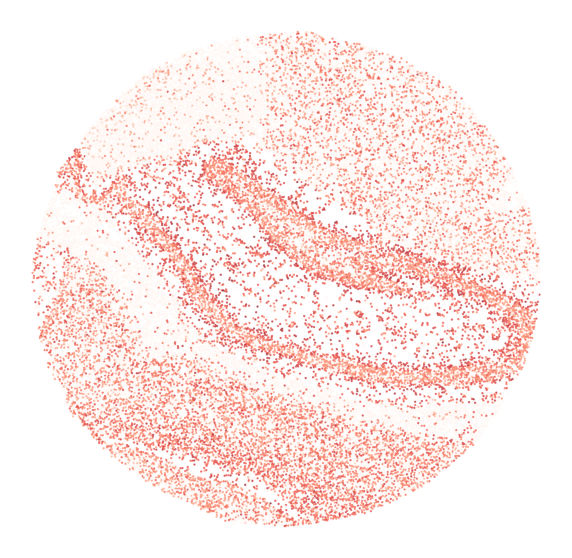

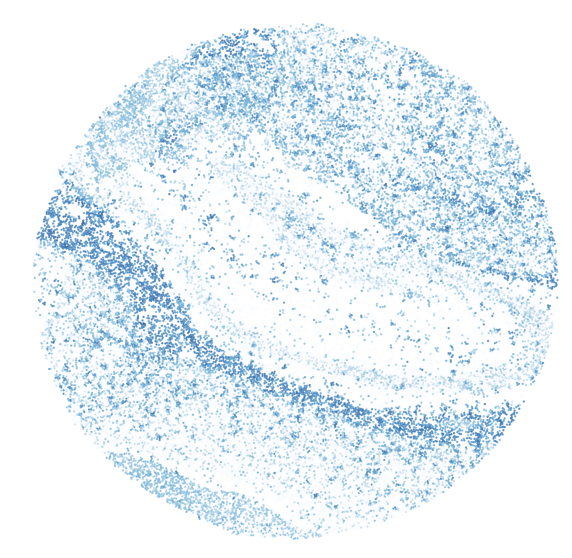

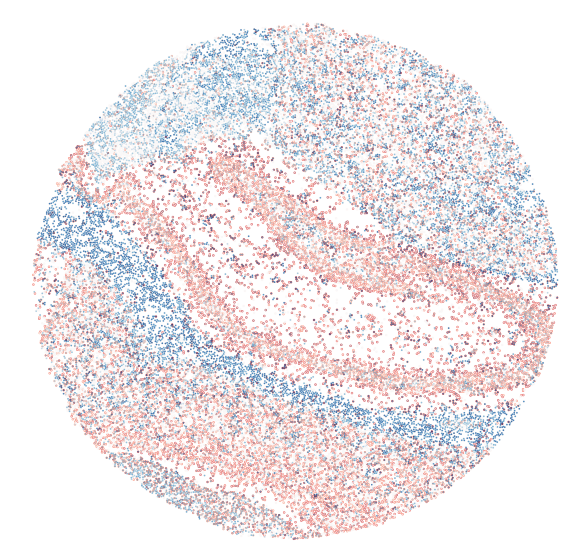

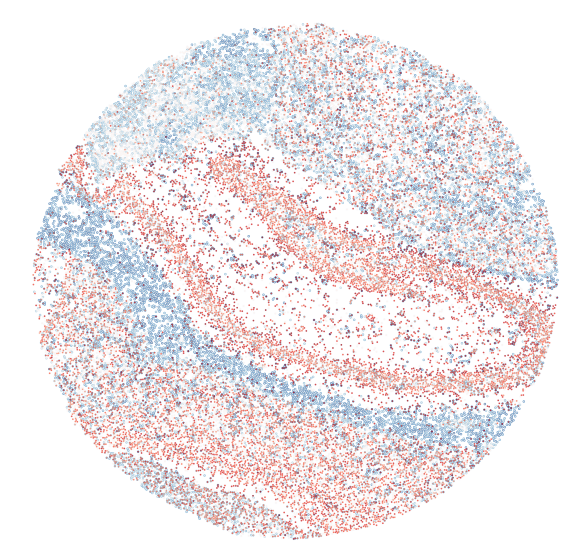

In [51]:
Vis.Superimpose(adata, G1 = 'CAMK2A', G2 = 'PLP1')

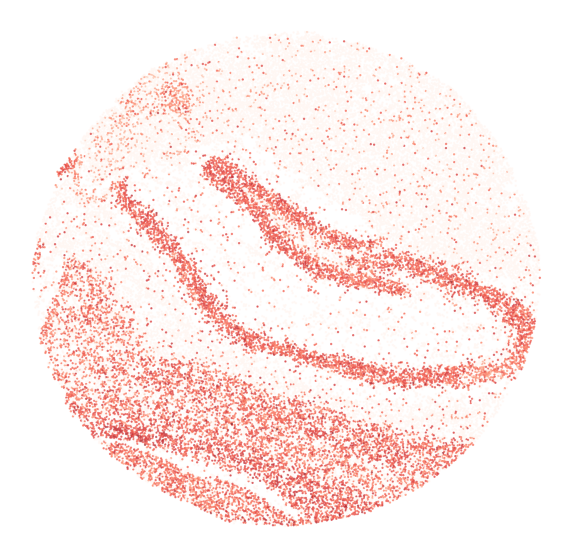

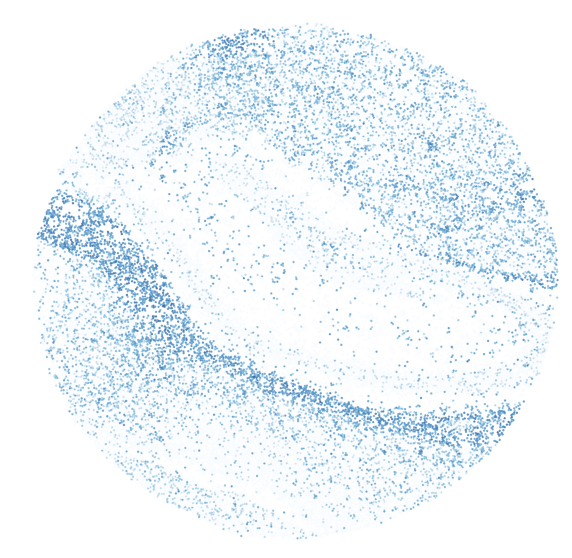

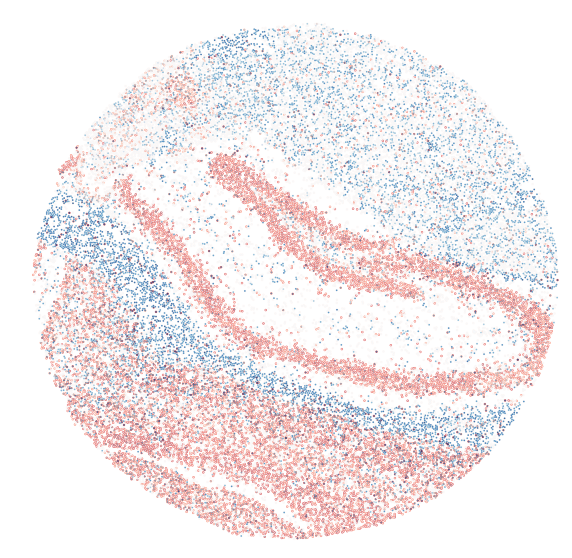

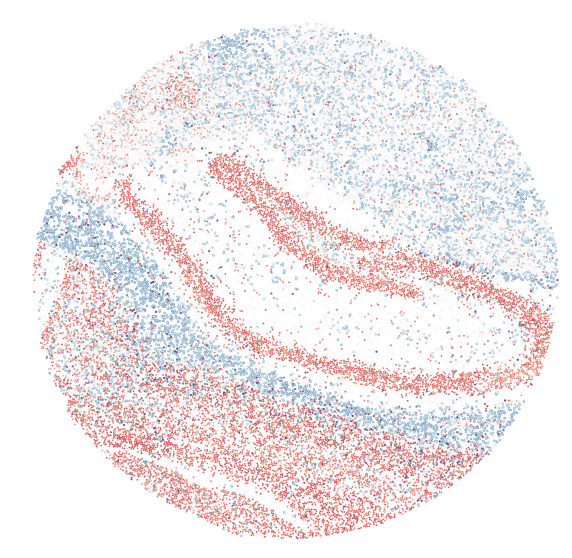

In [59]:
Vis.Superimpose(adata, G1 = 'NRGN', G2 = 'MOBP')

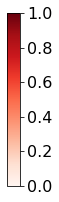

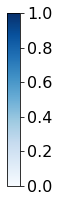

In [58]:
Vis.draw_cb(cmap = 'Reds', figsize = (9, 1.5), save = 'figures/BME/colorbar_reds', size = 16)
Vis.draw_cb(cmap = 'Blues', figsize = (9, 1.5), save = 'figures/BME/colorbar_blues', size = 16)